## ESTIMAÇÃO DE MODELOS HIERÁRQUICOS LINEARES DE TRÊS NÍVEIS COM MEDIDAS REPETIDAS

In [26]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import statsmodels.api as sm # estimação de modelos
from pymer4.models import Lmer # estimação de modelos HLM3 neste código
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import gaussian_kde # inserção de KDEs em gráficos
from matplotlib.gridspec import GridSpec # plotagem de gráficos separados
import time # definição do intervalo de tempo entre gráficos com animação
import imageio # para geração de figura GIF
from tqdm import tqdm # adiciona um indicador de progresso do código

### DESCRIÇÃO E EXPLORAÇÃO DO DATASET 'desempenho_tempo_aluno_escola'

In [2]:
# Carregamento da base de dados 'desempenho_tempo_aluno_escola'
df_tempo_aluno_escola = pd.read_csv('/home/usp_ds_analytics/modelagem_multinivel/data/desempenho_tempo_aluno_escola.csv',
                                    delimiter=',')

# Visualização da base de dados 'desempenho_tempo_aluno_escola'
df_tempo_aluno_escola.tail()

,escola,estudante,mes,desempenho,ativ,texp
2435,15,609,4,100.000000,sim,9
2436,15,610,1,87.599998,sim,9
2437,15,610,2,92.599998,sim,9
2438,15,610,3,94.599998,sim,9
2439,15,610,4,100.000000,sim,9


In [3]:
# Atribuição de categorias para as variáveis 'estudante' e 'escola'
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('category')
df_tempo_aluno_escola['escola'] = df_tempo_aluno_escola['escola'].astype('category')

In [4]:
# Características das variáveis do dataset
df_tempo_aluno_escola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2440 entries, 0 to 2439
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   escola      2440 non-null   category
 1   estudante   2440 non-null   category
 2   mes         2440 non-null   int64   
 3   desempenho  2440 non-null   float64 
 4   ativ        2440 non-null   object  
 5   texp        2440 non-null   int64   
dtypes: category(2), float64(1), int64(2), object(1)
memory usage: 105.1+ KB


In [5]:
# Estatísticas univariadas
df_tempo_aluno_escola.describe()

,mes,desempenho,texp
count,2440.000000,2440.000000,2440.000000
mean,2.500000,68.341352,9.027869
std,1.118263,22.981531,7.655618
min,1.000000,10.500000,2.000000
25%,1.750000,49.574999,2.000000
50%,2.500000,70.300003,9.000000
75%,3.250000,88.500000,18.000000
max,4.000000,100.000000,20.000000


In [6]:
# In[2.1]: Estudo sobre o balanceamento dos dados em relação à quantidade de
#alunos por período analisado

df_tempo_aluno_escola.groupby('mes')['estudante'].count().reset_index()

,mes,estudante
0,1,610
1,2,610
2,3,610
3,4,610


In [7]:
# In[2.2]: Estudo sobre o desbalanceamento da quantidade de alunos aninhados
#em escolas
(df_tempo_aluno_escola.groupby('escola')['estudante'].count()/4).reset_index()

/tmp/ipykernel_282861/2137556268.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df_tempo_aluno_escola.groupby('escola')['estudante'].count()/4).reset_index()


,escola,estudante
0,1,47.0
1,2,25.0
2,3,48.0
3,4,20.0
4,5,48.0
5,6,30.0
6,7,28.0
7,8,35.0
8,9,44.0
9,10,33.0


In [8]:
# In[2.3]: Desempenho escolar médio dos estudantes em cada período (mês)
df_tempo_aluno_escola.groupby('mes')['desempenho'].mean().reset_index()

,mes,desempenho
0,1,61.654918
1,2,66.366065
2,3,70.611147
3,4,74.733279


<function matplotlib.pyplot.show(close=None, block=None)>

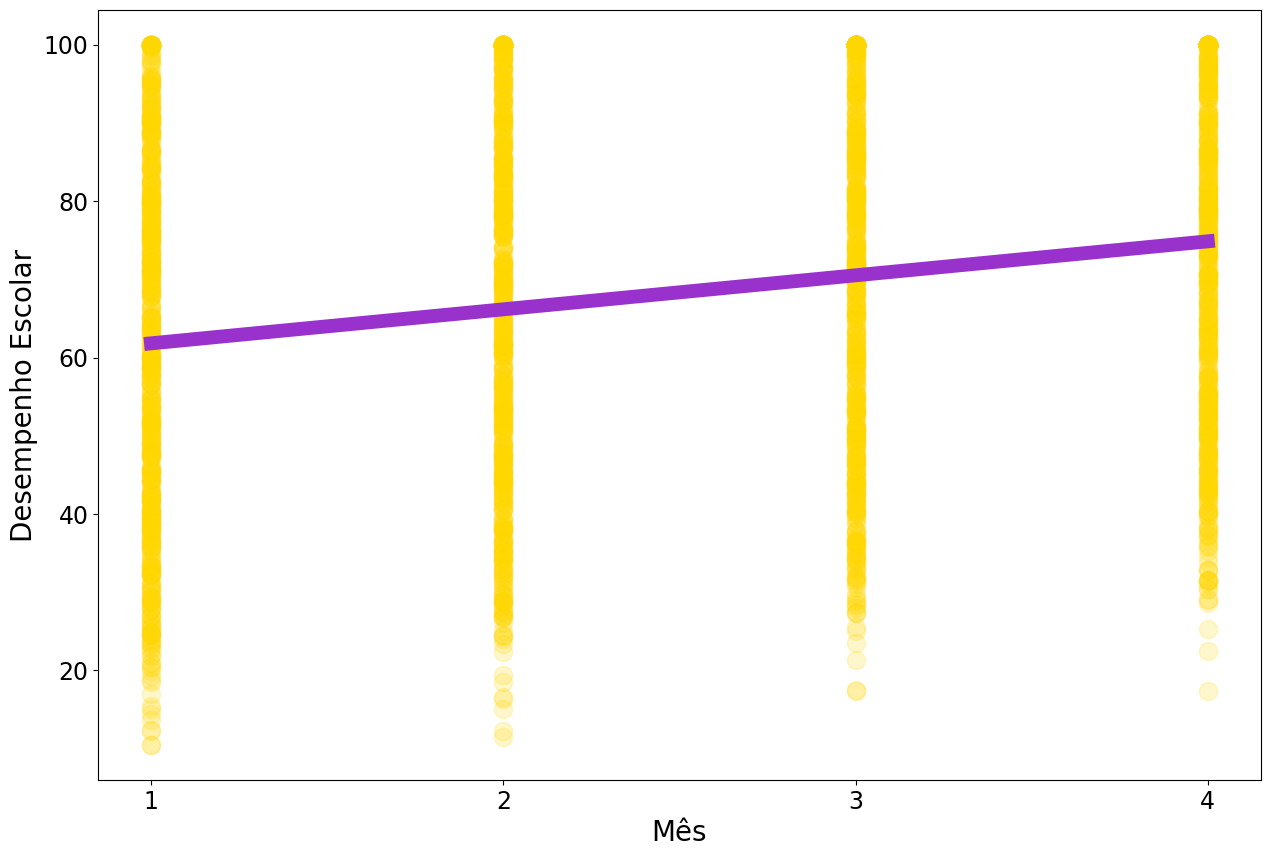

In [9]:
# In[2.4]: Gráfico com a evolução do desempenho escolar médio dos estudantes
#em cada período (ajuste linear)
plt.figure(figsize=(15,10))
sns.regplot(x=df_tempo_aluno_escola['mes'], 
            y=df_tempo_aluno_escola['desempenho'],
            ci=None, marker='o',
            scatter_kws={'color':'gold', 's':170, 'alpha':0.2},
            line_kws={'color':'darkorchid', 'linewidth':10})
plt.xlabel('Mês', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.xticks(np.arange(1, 5, 1))
plt.show

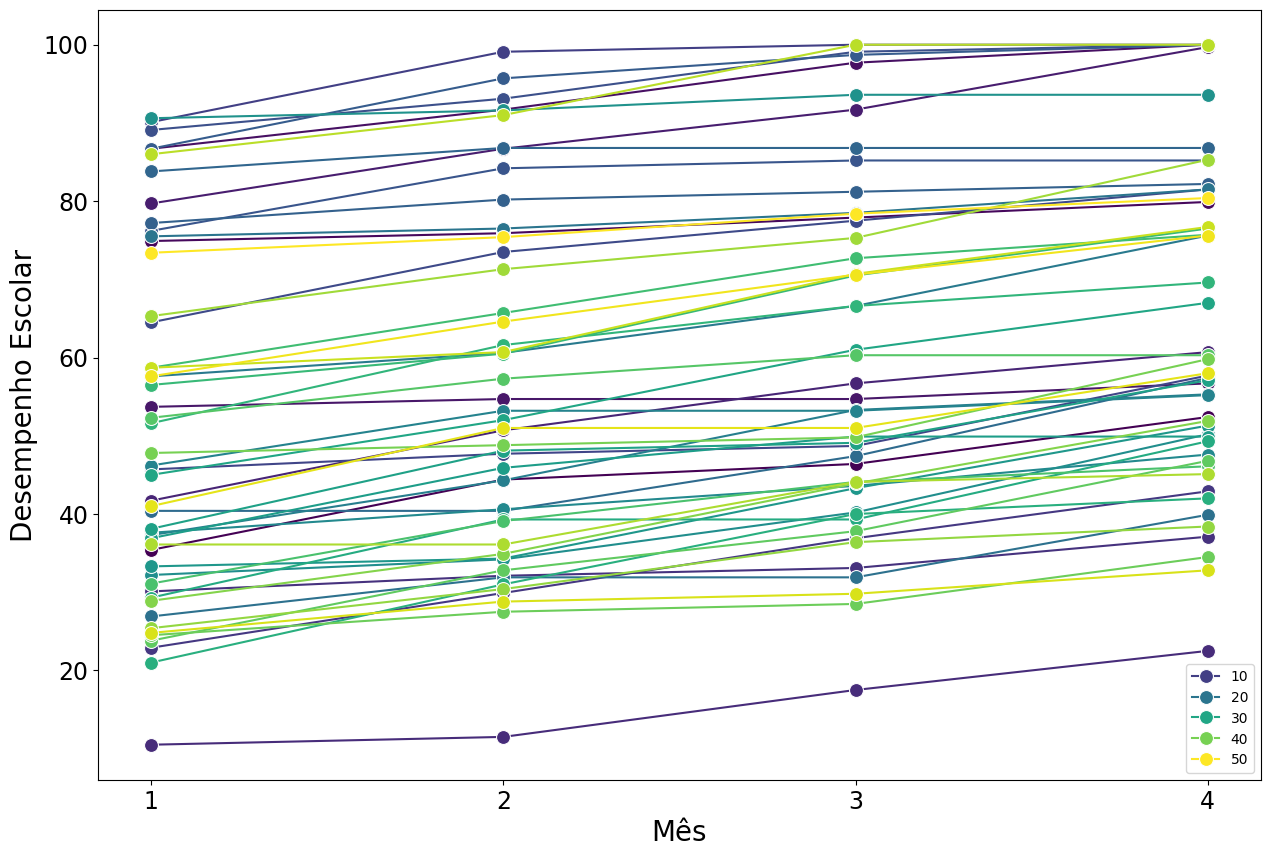

In [10]:
# In[2.5]: Gráfico com a evolução temporal do desempenho escolar dos 50 primeiros
#estudantes da amostra (50 estudantes em razão da visualização no gráfico)

# Seleção dos 50 primeiros estudantes
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('int')
df_amostra = df_tempo_aluno_escola[df_tempo_aluno_escola['estudante'] <= 50]
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('category')

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.lineplot(x='mes', y='desempenho', data=df_amostra,
             hue='estudante', marker="o", palette='viridis', markersize=10)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xlabel('Mês', fontsize=20)
plt.legend(loc='lower right')
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.xticks(np.arange(1, 5, 1))
plt.show()

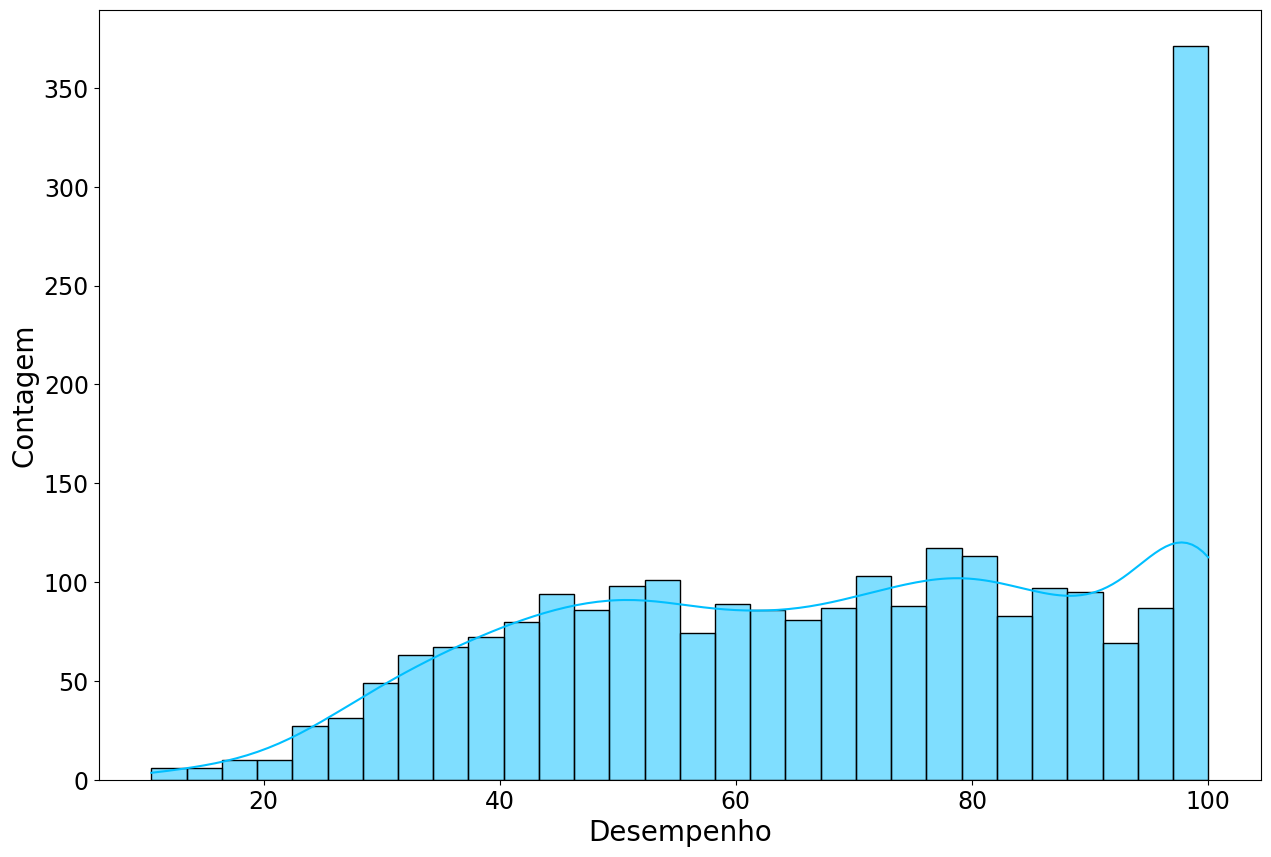

In [11]:
# In[2.6]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma
plt.figure(figsize=(15,10))
sns.histplot(data=df_tempo_aluno_escola.desempenho, kde=True,
             bins=30, color='deepskyblue')
plt.xlabel('Desempenho', fontsize=20)
plt.ylabel('Contagem', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

<Figure size 1500x1000 with 0 Axes>

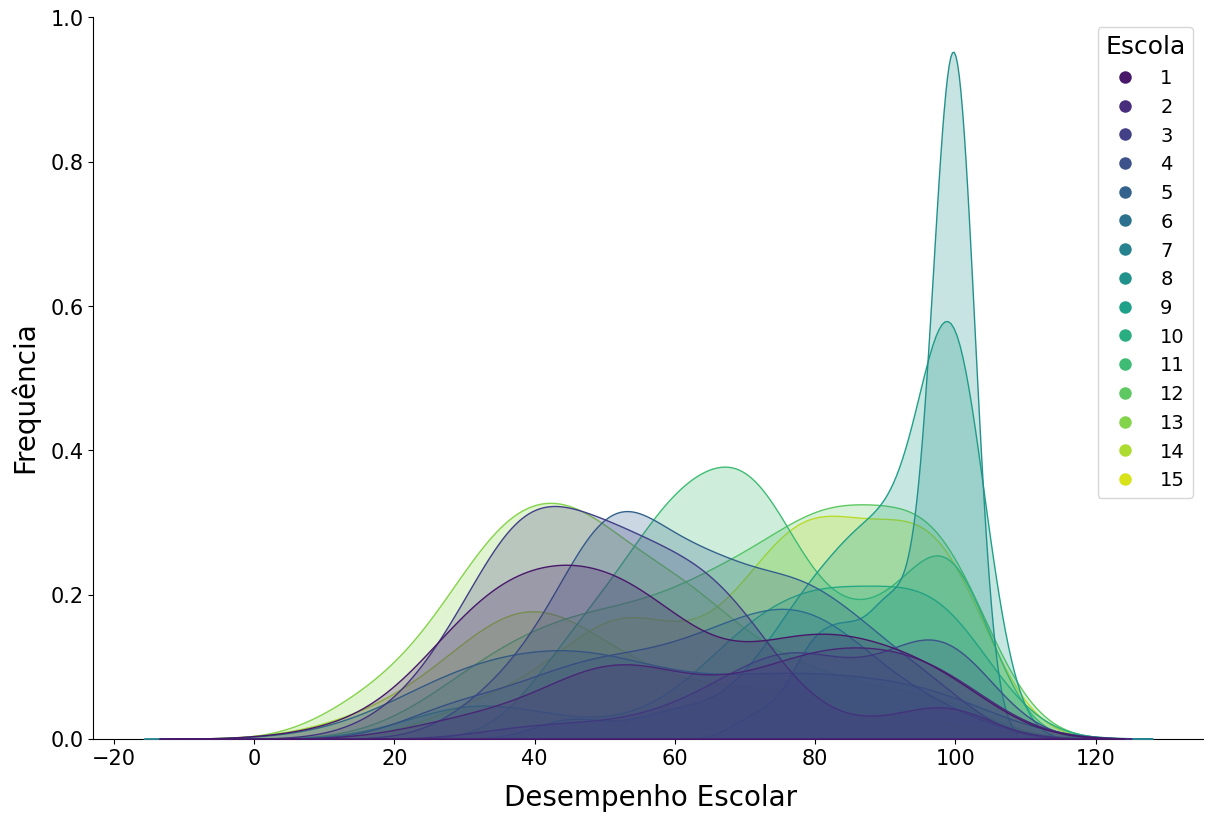

In [12]:
# In[2.7]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho') por escola
escolas = df_tempo_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

plt.figure(figsize=(15, 10))
g = sns.pairplot(df_tempo_aluno_escola[['escola', 'desempenho']], hue='escola',
                 height=8,
                 aspect=1.5, palette=colors)
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
g.tick_params(axis='both', which='major', labelsize=15)

# Gera a legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color,
                              markersize=10, label=escola)
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14,
           title_fontsize=18)

# Adiciona os rótulos diretamente na figura
plt.gcf().text(0.5, -0.01, 'Desempenho Escolar', ha='center', fontsize=20)
plt.gcf().text(-0.01, 0.5, 'Frequência', va='center', rotation='vertical',
               fontsize=20)
plt.show()

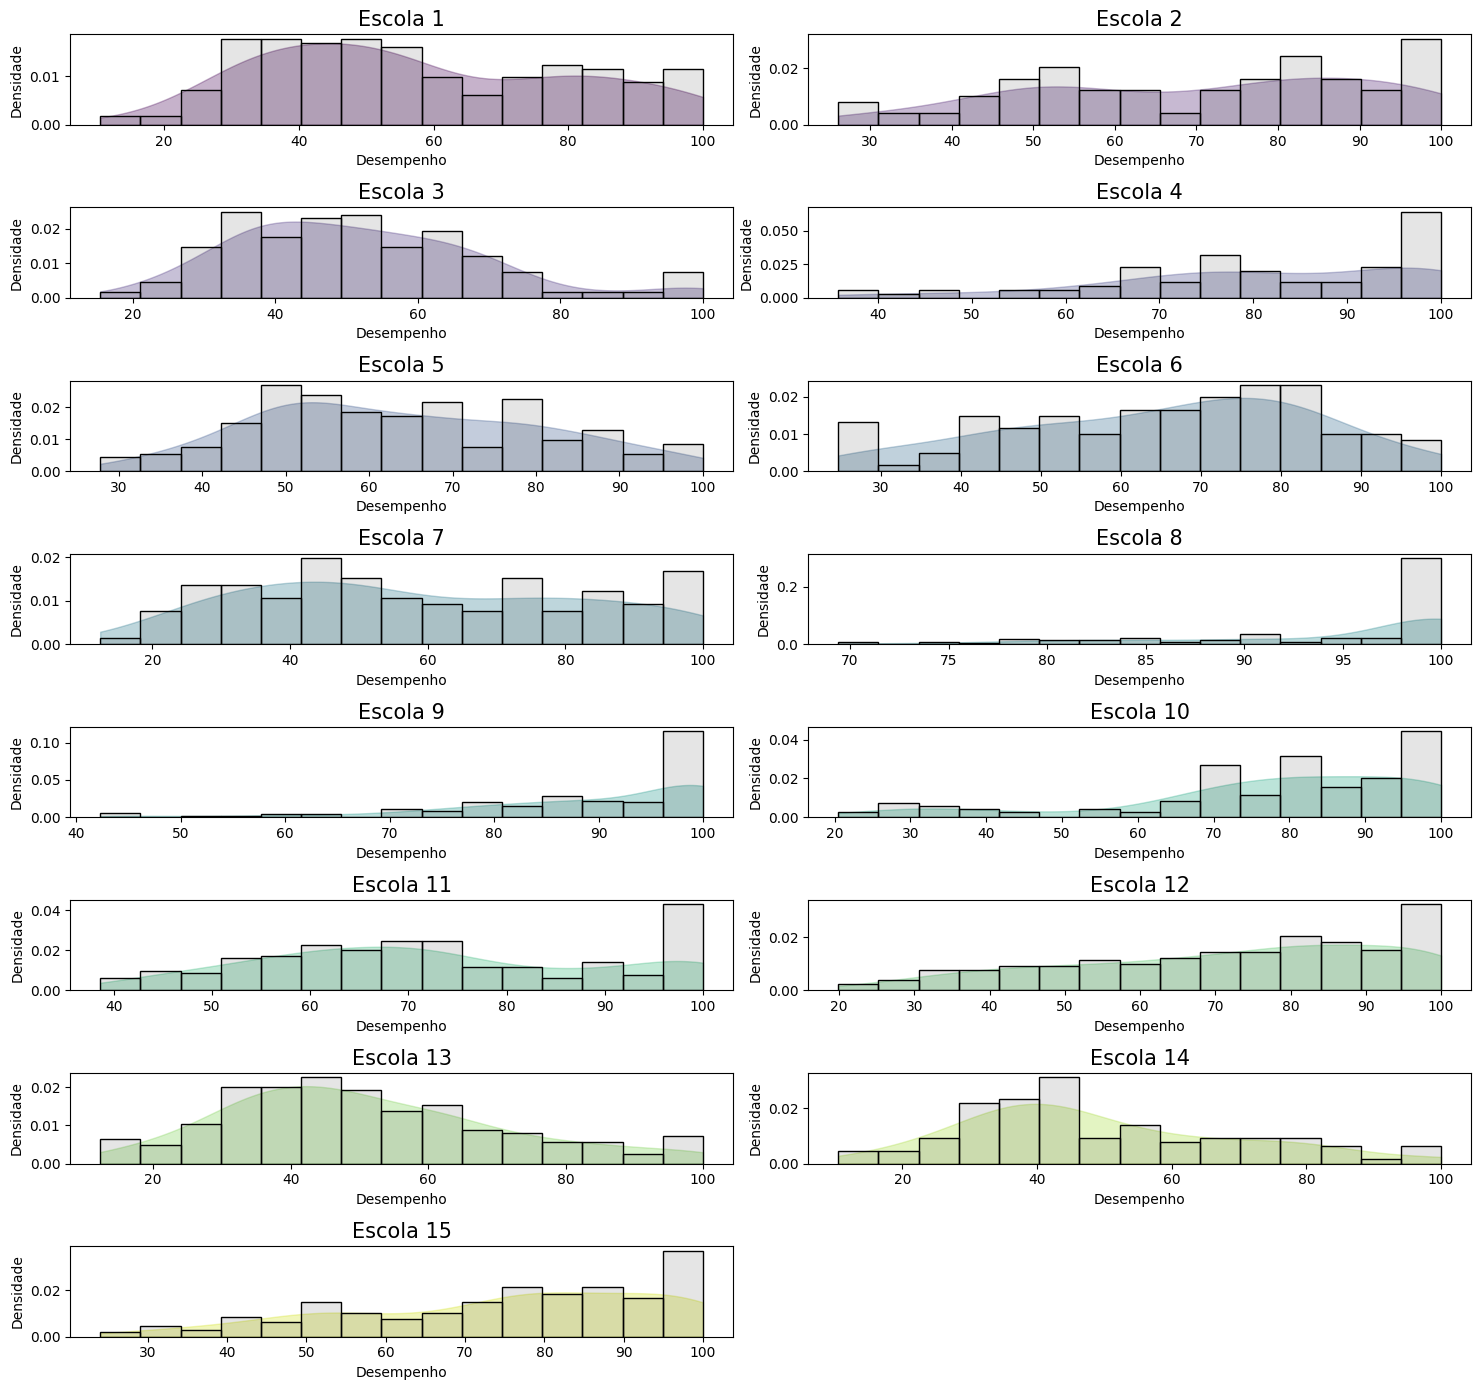

In [13]:
# In[2.8]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma e por escola separadamente
#(função 'GridSpec' do pacote 'matplotlib.gridspec')
escolas = df_tempo_aluno_escola['escola'].unique()

fig = plt.figure(figsize=(15, 14))
gs = GridSpec(len(escolas) // 2 + 1, 2, figure=fig)

for i, escola in enumerate(escolas):
    ax = fig.add_subplot(gs[i])

    # Subset dos dados por escola
    df_escola = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]

    # Densidade dos dados
    densidade = gaussian_kde(df_escola['desempenho'])
    x_vals = np.linspace(min(df_escola['desempenho']),
                         max(df_escola['desempenho']), len(df_escola))
    y_vals = densidade(x_vals)

    # Plotagem da density area
    ax.fill_between(x_vals, y_vals,
                    color=sns.color_palette('viridis',
                                            as_cmap=True)(i/len(escolas)),
                    alpha=0.3)
    
    # Adiciona o histograma
    sns.histplot(df_escola['desempenho'], ax=ax, stat="density", color="black",
                 edgecolor="black", fill=True, 
                 bins=15, alpha=0.1)
    ax.set_title(f'Escola {escola}', fontsize=15)
    ax.set_ylabel('Densidade')
    ax.set_xlabel('Desempenho')

plt.tight_layout()
plt.show()

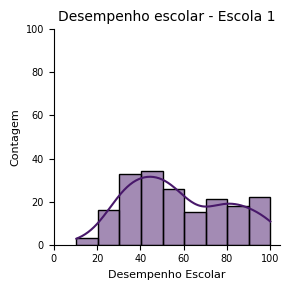

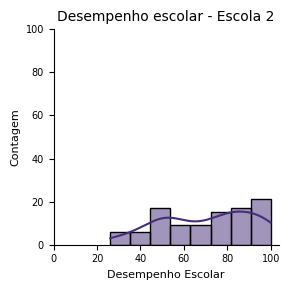

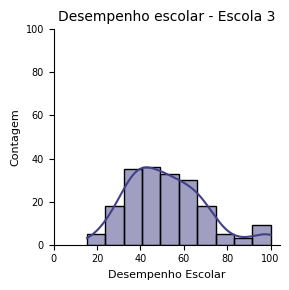

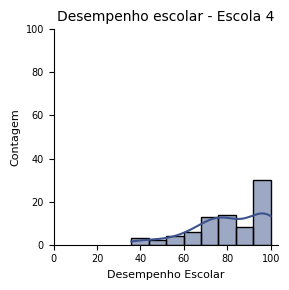

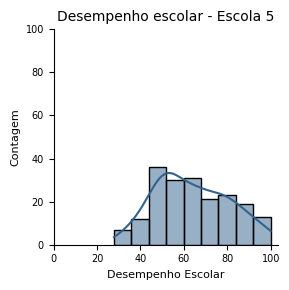

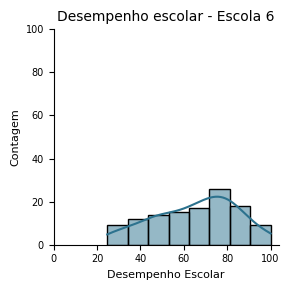

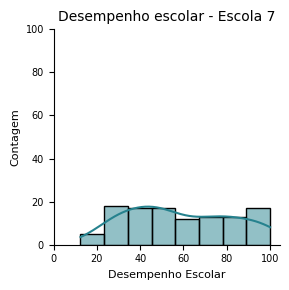

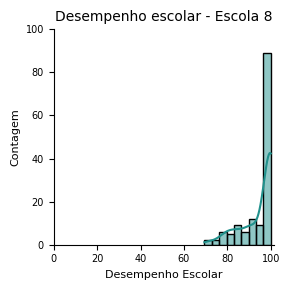

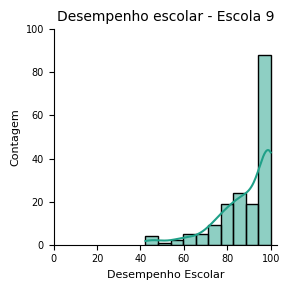

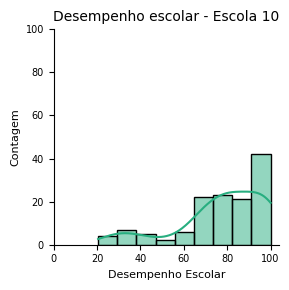

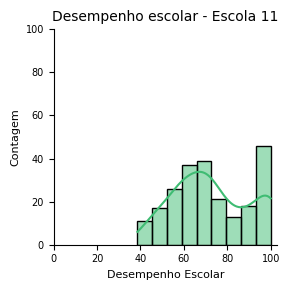

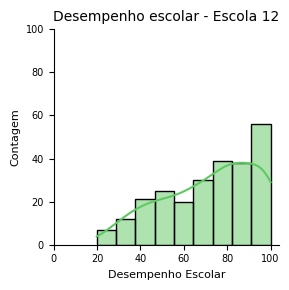

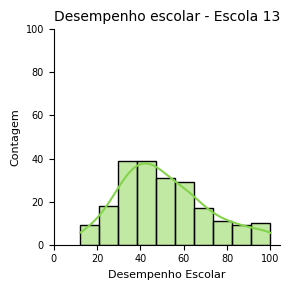

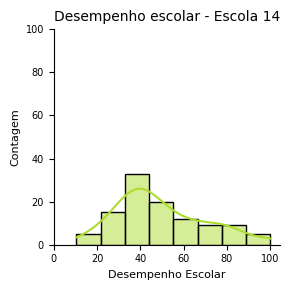

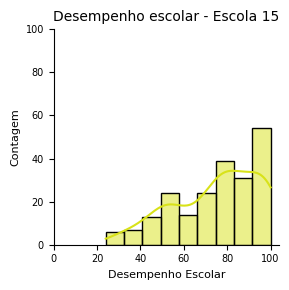

In [14]:
# In[2.9]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), por escola separadamente
# Animação no ambiente Plots
escolas = df_tempo_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

for escola in escolas:
    # Filtro dos dados para determinada escola
    data = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]
    # Criação do FacetGrid com a cor específica
    g = sns.FacetGrid(data, hue='escola', palette=[cor_escola[escola]])
    g.map(sns.histplot, 'desempenho', kde=True)
    g.ax.set_title(f"Desempenho escolar - Escola {escola}", fontsize=10)
    g.ax.set_xlabel('Desempenho Escolar', fontsize=8)
    g.ax.set_ylabel('Contagem', fontsize=8)
    g.ax.tick_params(axis='x', labelsize=7)
    g.ax.tick_params(axis='y', labelsize=7)
    # Ajustar os rótulos dos eixos
    plt.xticks(np.arange(0, 101, 20))
    plt.yticks(np.arange(0, 101, 20))
    plt.tight_layout()
    
    # Plotagem da figura
    plt.show()
    # Intervalo de tempo entre os gráficos
    time.sleep(1)

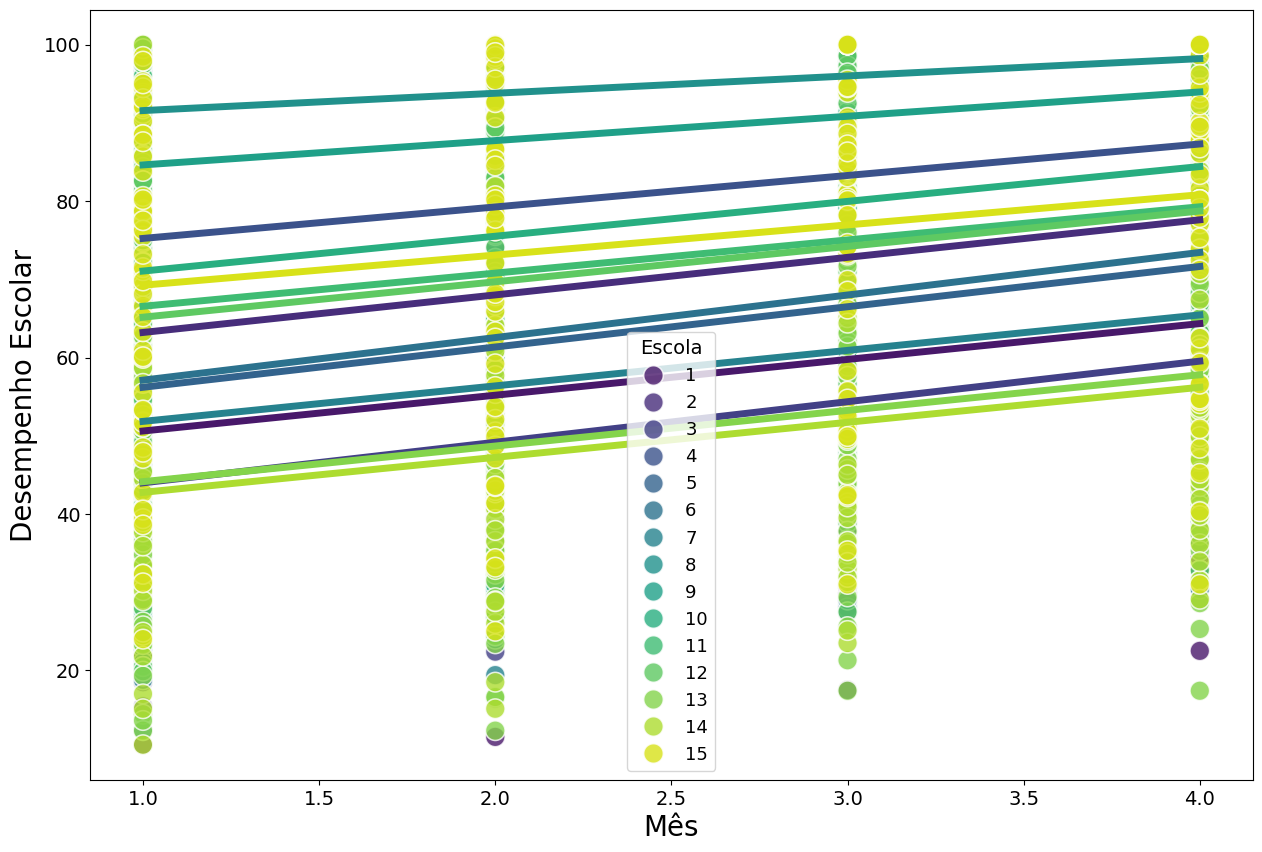

In [15]:
# In[2.10]: Gráfico da evolução temporal do desempenho médio por escola
#(ajustes lineares)
# NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO
#HETEROCEDÁSTICO NOS DADOS!

palette = sns.color_palette('viridis',
                            len(df_tempo_aluno_escola['escola'].unique()))

plt.figure(figsize=(15,10))
sns.scatterplot(data=df_tempo_aluno_escola, x='mes', y='desempenho', hue='escola',
                palette=palette, s=200, alpha=0.8, edgecolor='w')

for escola in df_tempo_aluno_escola['escola'].cat.categories:
    subset = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]
    sns.regplot(data=subset, x='mes', y='desempenho', scatter=False, ci=False,
                line_kws={"color": palette[df_tempo_aluno_escola['escola'].\
                                           cat.categories.get_loc(escola)],
                          'linewidth': 5})

plt.xlabel('Mês', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Escola', title_fontsize='14', fontsize='13', loc='best')
plt.show()

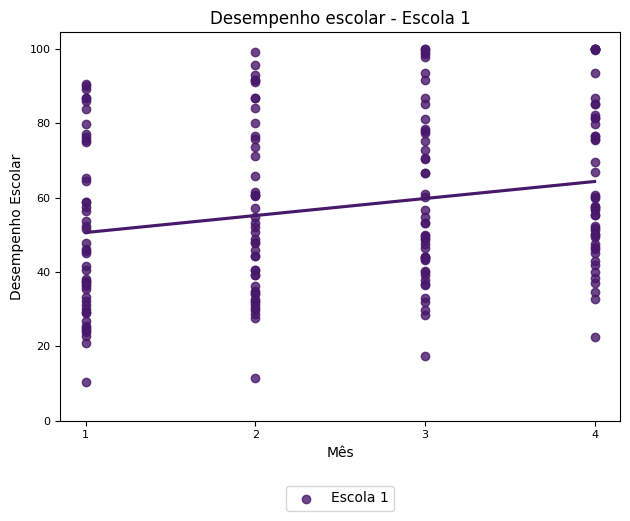

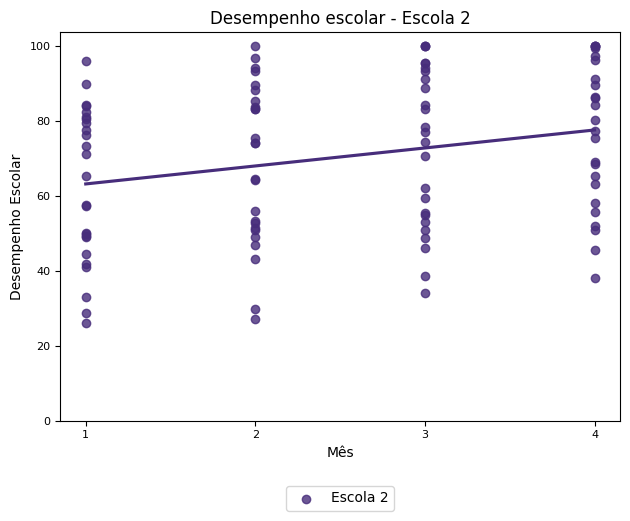

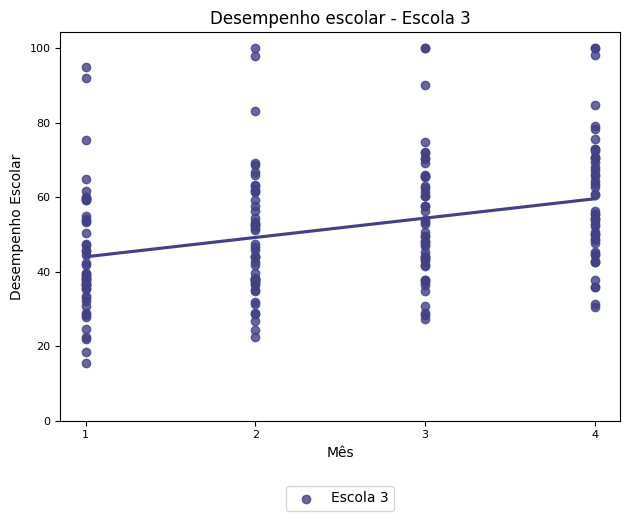

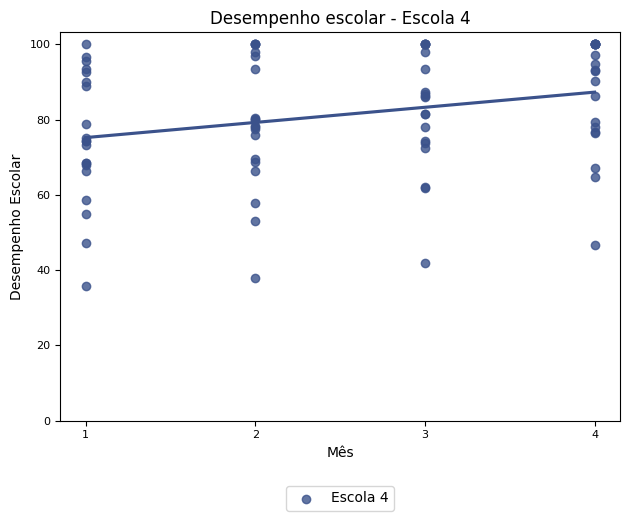

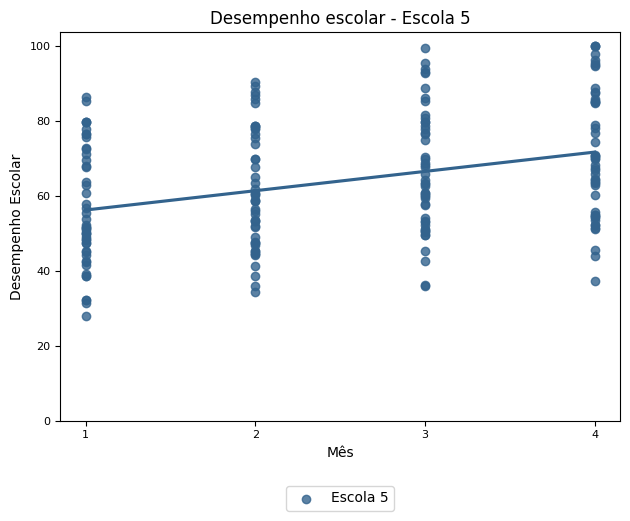

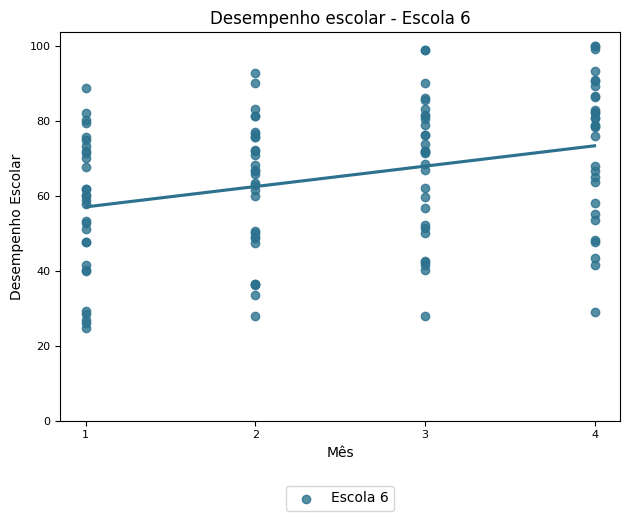

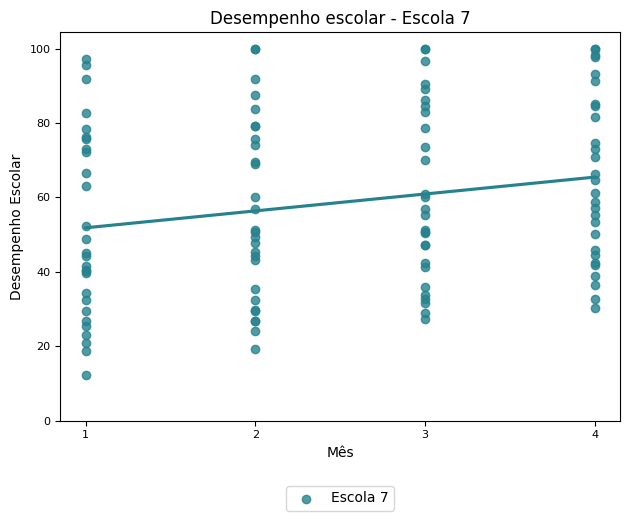

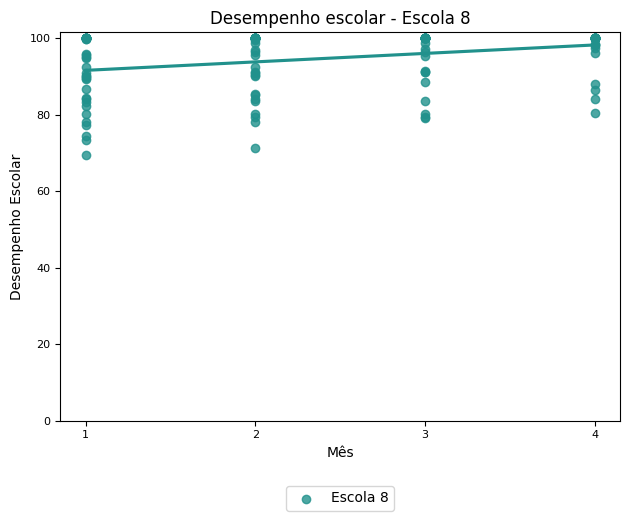

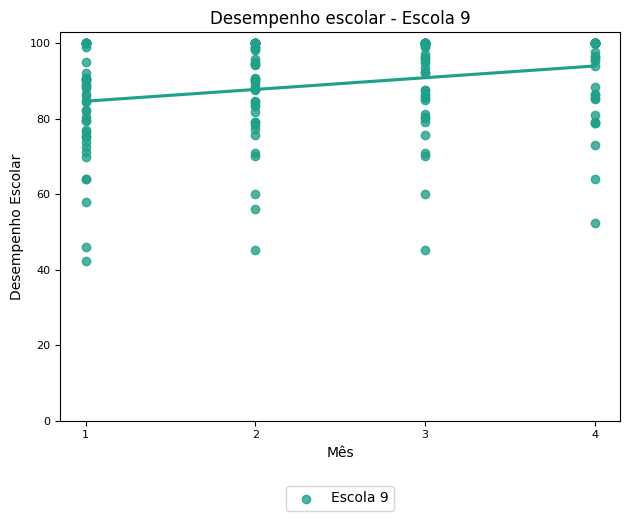

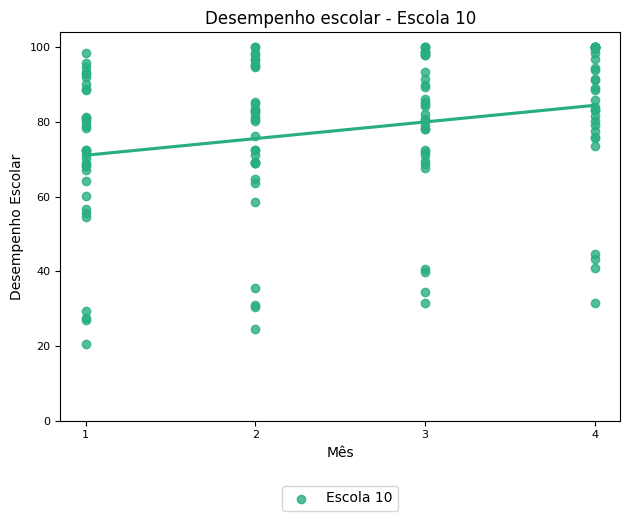

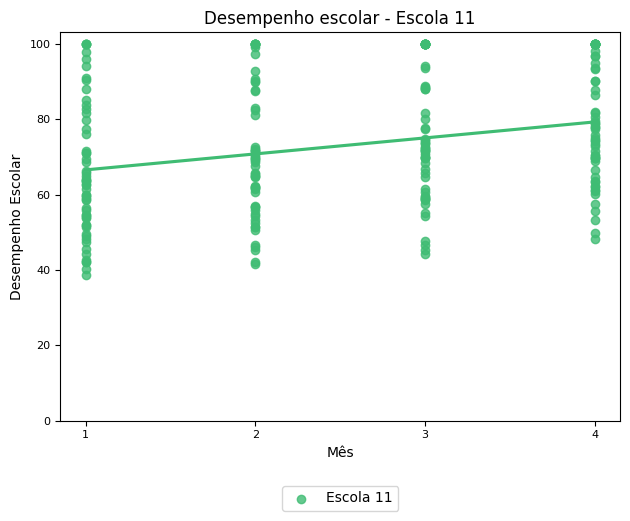

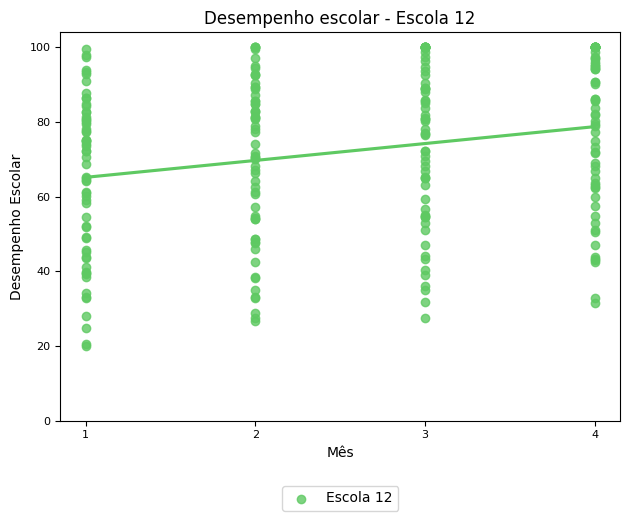

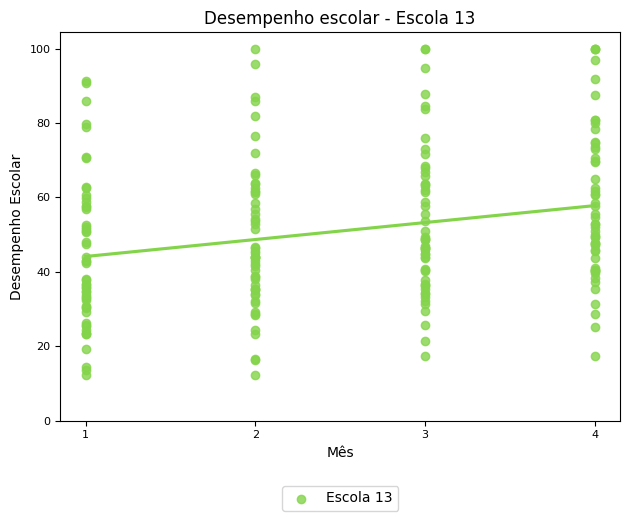

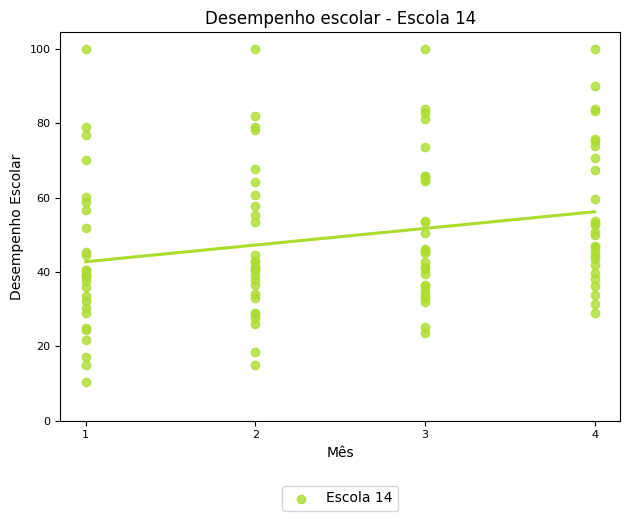

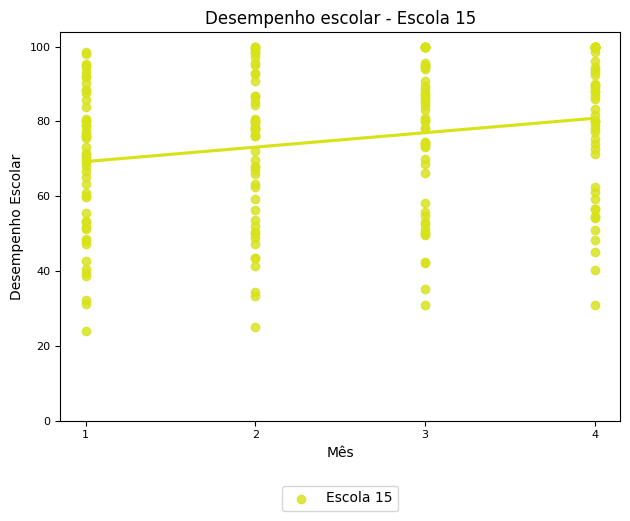

In [16]:
# In[2.11]: Gráfico de desempenho x mês por escola separadamente
# Animação no ambiente Plots
escolas = df_tempo_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

for escola in escolas:
    # Filtro dos dados para determinada escola
    data = df_tempo_aluno_escola[df_tempo_aluno_escola['escola'] == escola]
    # Criação da figura e dos eixos separadamente
    fig, ax = plt.subplots()
    
    # Criação do lmplot com a cor específica
    sns.regplot(x='mes', y='desempenho', data=data, color=cor_escola[escola],
                ax=ax, ci=False)
    plt.title(f"Desempenho escolar - Escola {escola}", fontsize=12)
    plt.xlabel("Mês", fontsize=10)
    plt.ylabel("Desempenho Escolar", fontsize=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    plt.yticks(np.arange(0, 101, 20))
    plt.xticks(np.arange(1, 5, 1))
    plt.tight_layout()
    ax.legend([f'Escola {escola}'], loc='upper center',
              bbox_to_anchor=(.5, -0.15), ncol=1)
    # Plotagem da figura
    plt.show()
    # Intervalo de tempo entre os gráficos
    time.sleep(1)

### ESTIMAÇÃO DO MODELO NULO HLM3

In [17]:
# Estimação do modelo nulo (função 'MixedLM' do pacote 'statsmodels')
modelo_nulo_hlm3 = sm.MixedLM.from_formula(formula='desempenho ~ 1',
                                           groups='escola',
                                           re_formula='1',
                                           vc_formula={'estudante': '0 + C(estudante)'},
                                           data=df_tempo_aluno_escola).fit()

# Parâmetros do 'modelo_nulo_hlm3'
modelo_nulo_hlm3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: desempenho
No. Observations:  2440    Method:             REML      
No. Groups:        15      Scale:              41.6494   
Min. group size:   80      Log-Likelihood:     -9092.1387
Max. group size:   248     Converged:          Yes       
Mean group size:   162.7                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      68.714    3.553 19.337 0.000 61.749 75.679
escola Var    180.222   11.137                           
estudante Var 325.798    3.477                           
=========================================================

"""

In [18]:
# ICCS (intraclasses correlations):
icc_escola = 180.222 / (180.222 + 325.798 + 41.6494)
icc_escola


0.3290707861348471

In [19]:
icc_estudante = 325.798 / (180.222 + 325.798 + 41.6494)
icc_estudante

0.5948807802663432

In [20]:
icc_temporal = 1 - icc_escola - icc_estudante
icc_temporal

0.07604843359880975

- 32% é devido ao efeito escola
- 59% é devido ao efeito estudante

A partir deste momento, iremos estimar os modelos multinível HLM3 com medidas repetidas por meio da função `Lmer` do pacote `pymer4.models`,
já que esta função permite que sejam considerados efeitos aleatórios de inclinação para os níveis 2 e 3 simultaneamente, ao contrário da função `MixedLM` do pacote `statsmodels`, que permite a inclusão de tais efeitos em apenas um dos níveis contextuais.

In [27]:
# Transformação das variáveis 'estudante' e 'escola' para 'int64', a fim de que
#seja possível estimar os modelos multinível por meio da função 'Lmer' do
#pacote 'pymer4.models'
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('int64')
df_tempo_aluno_escola['escola'] = df_tempo_aluno_escola['escola'].astype('int64')

# Estimação do modelo nulo (função 'Lmer' do pacote 'pymer4.models')

modelo_nulo_hlm3 = Lmer(formula='desempenho ~ 1 + (1|escola) + (1|estudante)',
                        data=df_tempo_aluno_escola)

# Parâmetros do 'modelo_nulo_hlm3'
modelo_nulo_hlm3.fit()

Linear mixed model fit by REML [’lmerMod’]
Formula: desempenho~1+(1|escola)+(1|estudante)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -9092.139 	 AIC: 18192.277

Random effects:

                  Name      Var     Std
estudante  (Intercept)  325.799  18.050
escola     (Intercept)  180.189  13.423
Residual                 41.649   6.454

No random effect correlations specified

Fixed effects:



/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),68.714,61.75,75.678,3.553,13.983,19.339,0.0,***


### COMPARAÇÃO DO HLM3 NULO COM UM OLS NULO

In [28]:
# Estimação de um modelo OLS nulo
modelo_ols_nulo = sm.OLS.from_formula(formula='desempenho ~ 1',
                                      data=df_tempo_aluno_escola).fit()

# Parâmetros do 'modelo_ols_nulo'
modelo_ols_nulo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 07 Oct 2024   Prob (F-statistic):                nan
Time:                        19:55:29   Log-Likelihood:                -11110.
No. Observations:                2440   AIC:                         2.222e+04
Df Residuals:                    2439   BIC:                         2.223e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.3414      0.465    146.892      0.000      67.429      69.254
==============================================================================
Omnibus:                      742.376   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.934
Skew:                          -0.230   Prob(JB):                     8.25e-30
Kurtosis:                       1.949   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

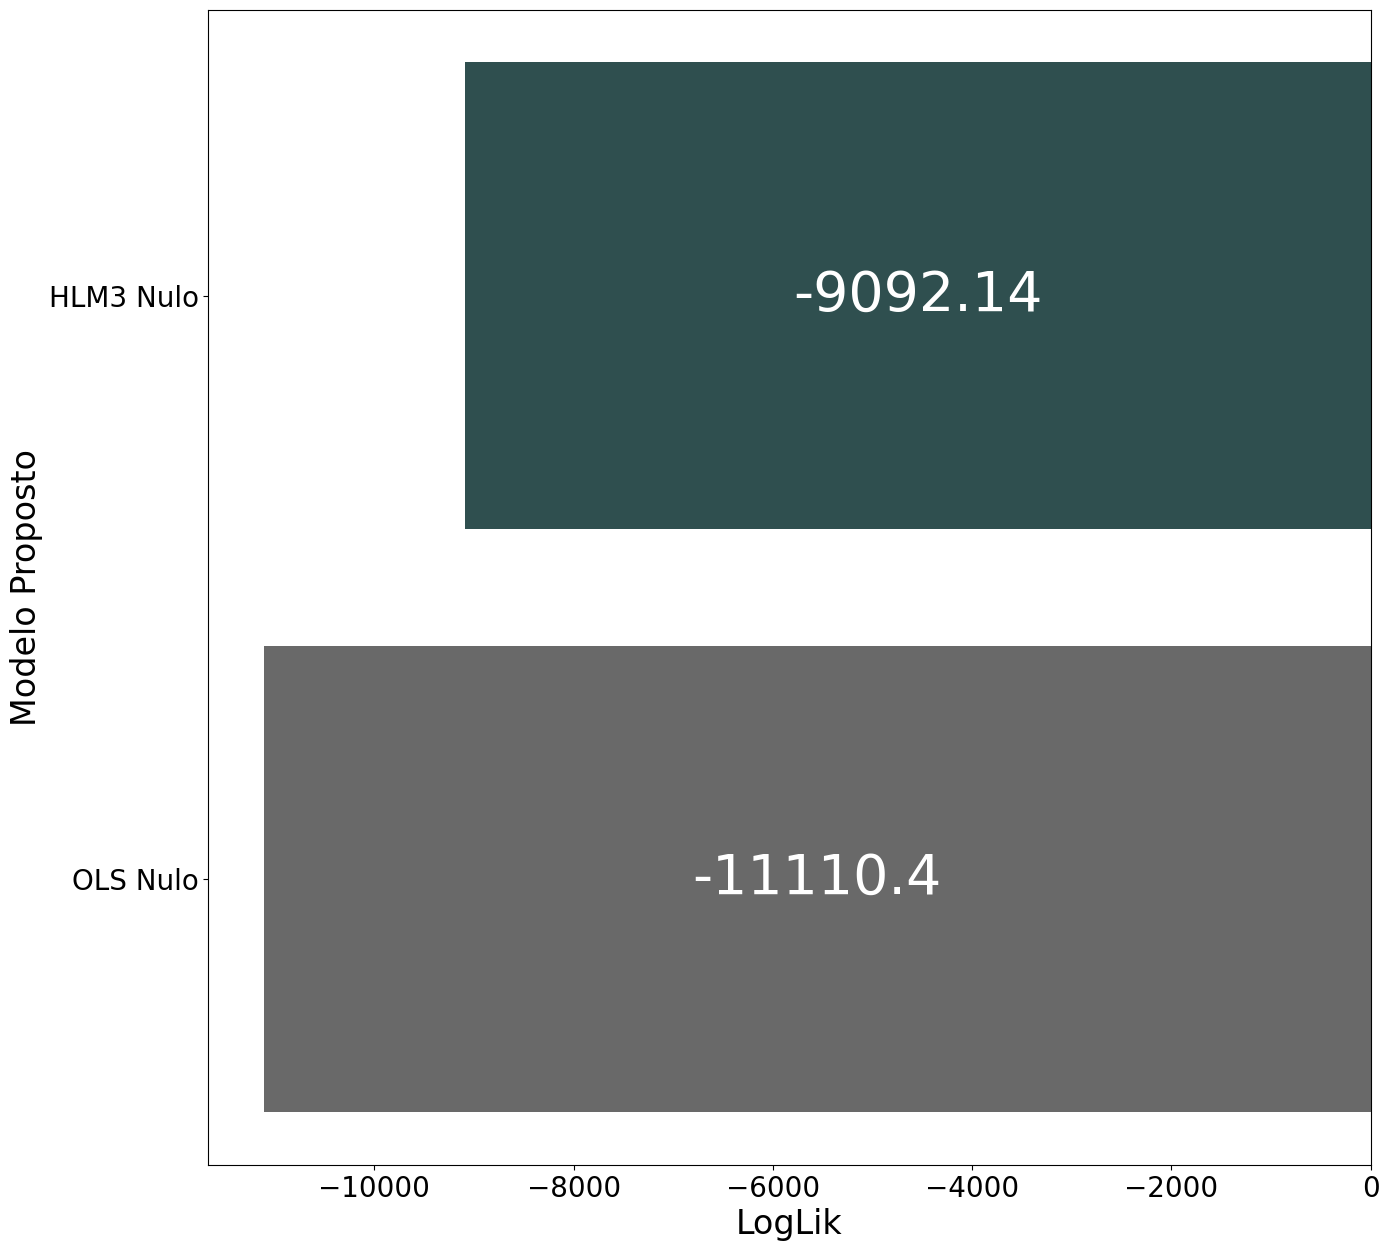

In [29]:
# In[2.15]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento
df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM3 Nulo'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [30]:
# In[2.16]: Teste de razão de verossimilhança entre o 'modelo_nulo_hlm3' e o
#'modelo_ols_nulo'

# Definição da função 'lrtest'
# ATENÇÃO: o valor de log-likelihood de modelos estimados por meio da função
#'Lmer' do pacote 'pymer4.models' é obtido pelo argumento '.logLike'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelos[1].logLike
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].logLike
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 2) # 2 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[2.17]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_ols_nulo' e 'modelo_nulo_hlm3'

lrtest([modelo_ols_nulo, modelo_nulo_hlm3])

Likelihood Ratio Test:
-2.(LL0-LLm): 4036.43
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


### ESTIMAÇÃO DO MODELO HLM3 COM TENDÊNCIA LINEAR E INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS    

In [31]:
# Estimação do modelo com tendência linear e interceptos e inclinações aleatórios
modelo_intercept_inclin_hlm3 = Lmer('desempenho ~ mes + (mes|escola) + (mes|estudante)',
                                    data = df_tempo_aluno_escola)

# Parâmetros do 'modelo_intercept_inclin_hlm3'
modelo_intercept_inclin_hlm3.fit()

Linear mixed model fit by REML [’lmerMod’]
Formula: desempenho~mes+(mes|escola)+(mes|estudante)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -7411.506 	 AIC: 14841.013

Random effects:

                  Name      Var     Std
estudante  (Intercept)  388.982  19.723
estudante          mes    3.325   1.823
escola     (Intercept)  225.474  15.016
escola             mes    0.553   0.744
Residual                  3.795   1.948

                   IV1  IV2   Corr
estudante  (Intercept)  mes -0.414
escola     (Intercept)  mes -0.880

Fixed effects:



/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),57.856,50.078,65.635,3.969,13.994,14.578,0.0,***
mes,4.337,3.925,4.748,0.210,13.820,20.664,0.0,***


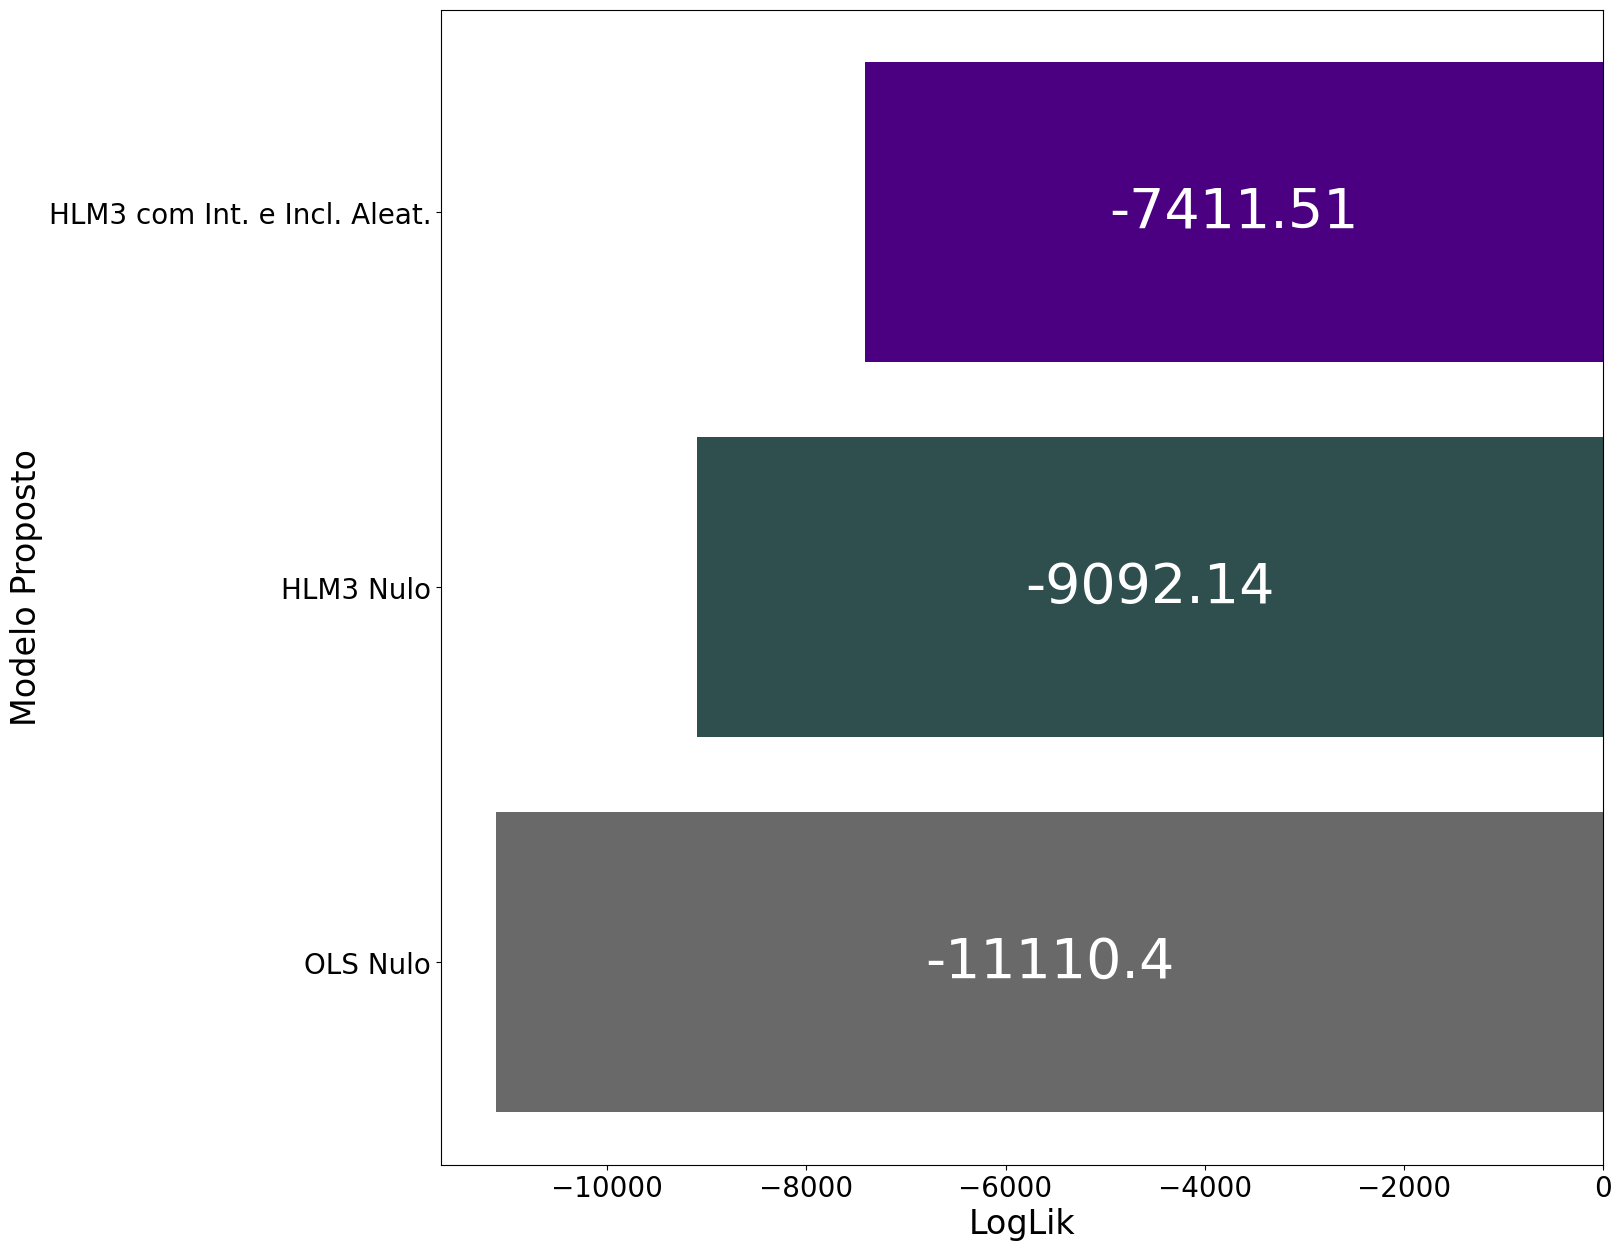

In [32]:
# In[2.19]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento
df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM3 Nulo',
                                 'HLM3 com Int. e Incl. Aleat.'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm3.logLike,
                                modelo_intercept_inclin_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [33]:
# In[2.20]: Teste de razão de verossimilhança para comparar as estimações do
#modelo HLM3 nulo e do presente modelo

# Definição da função 'lrtest2'
# ATENÇÃO: o valor de log-likelihood de modelos estimados por meio da função
#'Lmer' do pacote 'pymer4.models' é obtido pelo argumento '.logLike'

def lrtest2(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.logLike
    llk_2 = modelos[1].logLike
    
    if len(modelos)>1:
        llk_1 = modelo_1.logLike
        llk_2 = modelos[1].logLike
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 3) # 3 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[2.21]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_nulo_hlm3' e 'modelo_intercept_inclin_hlm3'

lrtest2([modelo_nulo_hlm3, modelo_intercept_inclin_hlm3])

Likelihood Ratio Test:
-2.(LL0-LLm): 3361.26
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


### ESTIMAÇÃO DO MODELO HLM3 COM TENDÊNCIA LINEAR, INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS E AS VARIÁVEIS 'ativ' DE NÍVEL 2 E 'text' DE NÍVEL 3 

> continua em 3'04"

Dummização da variável preditora qualitativa 'ativ', a fim de que seja possível estabelecer, adiante, as funções para a definição dos efeitos aleatórios dos níveis contextuais.

In [ ]:
df_tempo_aluno_escola = pd.get_dummies(df_tempo_aluno_escola, columns=['ativ'],
                                       dtype=int,
                                       drop_first=True)

In [ ]:
# Estimação do modelo com tendência linear, interceptos e inclinações aleatórios
#e as variáveis 'ativ' de nível 2 e 'texp' de nível 3

modelo_completo_final_hlm3 = Lmer('desempenho ~ mes + ativ_sim + texp +\
                                  ativ_sim:mes + texp:mes +\
                                      (mes|escola) + (mes|estudante)',
                                      data = df_tempo_aluno_escola)

# Parâmetros do 'modelo_completo_final_hlm3'
modelo_completo_final_hlm3.fit()

In [ ]:
# In[2.23]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM3 Nulo',
                                 'HLM3 com Int. e Incl. Aleat.',
                                 'HLM3 Completo Níveis 2 e 3'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm3.logLike,
                                modelo_intercept_inclin_hlm3.logLike,
                                modelo_completo_final_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo','purple']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [ ]:
# In[2.24]: Teste de razão de verossimilhança para comparar as estimações do
#presente modelo e do modelo anterior

# Definição da função 'lrtest3'

def lrtest3(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.logLike
    llk_2 = modelos[1].logLike
    
    if len(modelos)>1:
        llk_1 = modelo_1.logLike
        llk_2 = modelos[1].logLike
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 4) # 4 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[2.25]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_intercept_inclin_hlm3' e 'modelo_completo_final_hlm3'

lrtest3([modelo_intercept_inclin_hlm3, modelo_completo_final_hlm3])

In [ ]:
# In[2.26]: Visualização dos interceptos e inclinações aleatórios por estudante

# Valores de v0jk e v1jk para o 'modelo_completo_final_hlm3' (efeitos aleatórios
#de intercepto e de inclinação no nível estudante, respectivamente)

aleat_estudante = pd.DataFrame(modelo_completo_final_hlm3.ranef[0]).dropna()
aleat_estudante = aleat_estudante.rename(columns={'(Intercept)':'v0jk','mes':'v1jk'})
aleat_estudante = aleat_estudante.reset_index().rename(columns={'index': 'estudante'})
aleat_estudante

In [ ]:
# In[2.27]: Visualização dos interceptos e inclinações aleatórios por escola

# Valores de t00k e t10k para o 'modelo_completo_final_hlm3' (efeitos aleatórios
#de intercepto e de inclinação no nível escola, respectivamente)

aleat_escola = pd.DataFrame(modelo_completo_final_hlm3.ranef[1]).dropna()
aleat_escola = aleat_escola.rename(columns={'(Intercept)':'t00k','mes':'t10k'})
aleat_escola = aleat_escola.reset_index().rename(columns={'index': 'escola'})
aleat_escola

In [ ]:
# In[2.28]: Gráfico para visualização do comportamento dos valores de t00k,
#ou seja, dos interceptos aleatórios por escola

colors = ['springgreen' if x > 0 else 'red' for x in aleat_escola['t00k']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'], 4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15, 10))
plt.barh(aleat_escola['escola'], aleat_escola['t00k'], color=colors)

label_point(x=aleat_escola['t00k'],
            y=aleat_escola['escola'],
            val=aleat_escola['t00k'],
            ax=plt.gca()) 

plt.ylabel('Escola', fontsize=20)
plt.xlabel('$\\tau_{00k}$', fontsize=20)
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)
plt.yticks(np.arange(0, 16, 1))
plt.show()

In [ ]:
# In[2.29]: Gráfico para visualização do comportamento dos valores de t10k,
#ou seja, das inclinações aleatórias por escola

colors = ['springgreen' if x>0 else 'red' for x in aleat_escola['t10k']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'],4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15,10))
plt.barh(aleat_escola['escola'], aleat_escola['t10k'], color=colors)

label_point(x = aleat_escola['t10k'],
            y = aleat_escola['escola'],
            val = aleat_escola['t10k'],
            ax = plt.gca()) 
plt.ylabel('Escola', fontsize=20)
plt.xlabel('$\\tau_{10k}$', fontsize=20)
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)
plt.yticks(np.arange(0, 16, 1))
plt.show()

In [ ]:
# In[2.30]: Definição da função 'predict_fixed' para o estabelecimento dos
#valores presentes no componente de efeitos fixos

def predict_fixed(df:pd.DataFrame, model:Lmer):
    
    coefs = list(model.coefs.index)
    intercept = model.coefs['Estimate'][coefs[0]]
    equation = [str(intercept)]
    
    for index, item in enumerate(coefs[1:]):
       
        if item.find(":") != -1:
            nested = item.split(":")
            equation.append(str(nested[0]) + " * " + str(nested[1]) + " * " + str(model.coefs['Estimate'][item]))
        
        else:
            equation.append(item + " * " + str(model.coefs['Estimate'][item]))
    
    final_equation = " + ".join(equation)
    
    final_equation = "fitted_fixed =" + final_equation
    
    return df.eval(final_equation)

In [ ]:
# In[2.31]: Dataframe com os valores presentes no componente de efeitos fixos
#(variável 'fitted_fixed')

df_tempo_aluno_escola = predict_fixed(df_tempo_aluno_escola,
                                      modelo_completo_final_hlm3)
df_tempo_aluno_escola

In [ ]:
# In[2.32]: Modo direto para a definição dos valores de 'fitted_completo'

df_tempo_aluno_escola['fitted_completo'] = pd.DataFrame(modelo_completo_final_hlm3.fits)

# In[2.33]: Definição dos valores de 'etjk'

df_tempo_aluno_escola['etjk'] = modelo_completo_final_hlm3.residuals

# In[2.34]: Visualização do dataframe 'df_effects' com os valores de
#'fitted_fixed', 'fitted_completo' e 'etjk'

df_effects = df_tempo_aluno_escola[['escola','estudante','mes','desempenho',
                                    'fitted_fixed','fitted_completo','etjk']]

df_effects

In [ ]:
# In[2.35]: Elaboração de previsões para o 'modelo_completo_final_hlm3':

# Exemplo: Quais os valores previstos de desempenho escolar no primeiro mês
#('mes' = 1) para o estudante '1' da escola '1', sabendo-se que esta escola
#oferece tempo médio de experiência de seus professores igual a 2 anos?

# Predict para ativ_sim = 0

pred_0 = modelo_completo_final_hlm3.predict(pd.DataFrame({'escola':[1],
                                                          'estudante':[1],
                                                          'mes':[1],
                                                          'ativ_sim':[0],
                                                          'texp':[2]}),
                                            skip_data_checks=True)
pred_0

In [ ]:
# Predict para ativ_sim = 1
#(caso o estudante passasse a realizar atividades complementares de estudo)

pred_1 = modelo_completo_final_hlm3.predict(pd.DataFrame({'escola':[1],
                                                          'estudante':[1],
                                                          'mes':[1],
                                                          'ativ_sim':[1],
                                                          'texp':[2]}),
                                            skip_data_checks=True)
pred_1

In [ ]:
# In[2.36]: Gráfico com os valores previstos do desempenho escolar ao longo do
#tempo para os 47 primeiros estudantes da amostra (47 estudantes que estão na
#escola '1')

df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('int')
df = df_tempo_aluno_escola[df_tempo_aluno_escola['estudante'] <= 47]
df_tempo_aluno_escola['estudante'] = df_tempo_aluno_escola['estudante'].astype('category')

plt.figure(figsize=(15, 10))
sns.set(style='whitegrid')
g = sns.lmplot(x='mes', y='fitted_completo', data=df, hue='estudante',
           ci=False, height=7, palette='viridis')
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
plt.ylabel('Desempenho Escolar', fontsize=14)
plt.xlabel('Mês', fontsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.xticks(np.arange(1, 5, 1))
legend = plt.legend(title='Estudante', fontsize=12, title_fontsize=14, ncol=2,
                    loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)
legend.get_title().set_position((10, 0))
plt.show()

In [ ]:
# In[2.37]:
##############################################################################
#          FINALIZANDO... COMPARAÇÃO COM UM MODELO OLS COM DUMMIES           #
##############################################################################

# Procedimento para criação de n-1 dummies para as escolas

base_para_dummies = df_tempo_aluno_escola[['estudante','escola','desempenho',
                                           'mes','texp','ativ_sim']]

base_dummizada = pd.get_dummies(base_para_dummies, columns=['escola'],
                                dtype=int,
                                drop_first=True)
base_dummizada

In [ ]:
# In[2.38]: Estimação de um modelo OLS com as mesmas variáveis do modelo HLM3

# Criação das variáveis multiplicativas e definição da expressão a ser
#utilizada no modelo

base_dummizada['ativ_mes'] = base_dummizada['ativ_sim'] * base_dummizada['mes']
base_dummizada['texp_mes'] = base_dummizada['texp'] * base_dummizada['mes']

lista_colunas = list(base_dummizada.drop(columns=['estudante',
                                                  'desempenho']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "desempenho ~ " + formula_dummies_modelo
formula_dummies_modelo

In [ ]:
# In[2.39]: Estimação do 'modelo_ols_dummies'

modelo_ols_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                         base_dummizada).fit()

# Parâmetros do 'modelo_ols_dummies'
modelo_ols_dummies.summary()


In [ ]:
# In[2.40]: Procedimento Stepwise para o 'modelo_ols_dummies'

# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.process import stepwise

# Estimação do modelo por meio do procedimento Stepwise

modelo_ols_dummies_step = stepwise(modelo_ols_dummies, pvalue_limit=0.05)



In [ ]:
# In[2.41]: Gráfico para comparação visual dos logLiks dos modelos HLM3
#completo e OLS com dummies e procedimento Stepwise

df_llf = pd.DataFrame({'modelo':['OLS Final com Stepwise',
                                 'HLM3 Completo Níveis 2 e 3'],
                      'loglik':[modelo_ols_dummies_step.llf,
                                modelo_completo_final_hlm3.logLike]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['salmon','purple']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()



In [ ]:
# In[2.42]: Gráfico para a comparação dos fitted values dos modelos HLM3
#completo e OLS com dummies e procedimento Stepwise

plt.figure(figsize=(15,10))
sns.regplot(x=df_tempo_aluno_escola['desempenho'],
            y=df_tempo_aluno_escola['desempenho'],
            ci=None,
            line_kws={'color':'black', 'linewidth':2, 'linestyle':'--'})
sns.regplot(x=df_tempo_aluno_escola['desempenho'],
            y=modelo_ols_dummies.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'salmon', 's':40, 'alpha':0.5},
            line_kws={'color':'salmon', 'linewidth':5,
                      'label':'OLS'})
sns.regplot(x=df_tempo_aluno_escola['desempenho'],
            y=df_tempo_aluno_escola['fitted_completo'],
            ci=None, marker='s', order=5,
            scatter_kws={'color':'purple', 's':40, 'alpha':0.5},
            line_kws={'color':'purple', 'linewidth':5,
                      'label':'HLM3'})
plt.xlabel('Desempenho', fontsize=20)
plt.ylabel('Fitted Values', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=20)
plt.show